In [1]:
from utils import FilteredImageFolder, count_trainable_parameters, count_elements_per_class, show_images, train_model
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import torch
import os

manualSeed = 999 
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


# Hyperparameters

In [2]:
batch_size = 32
learning_rate = 0.001
num_epochs = 3

# Datasets

In [3]:
data_dir = r"C:\Users\yaoko\Downloads\archive\fruits-360-original-size\fruits-360-original-size"
TRAIN = "train"
VAL = "val"
TEST = "test"
data_transforms = {
    TRAIN: transforms.Compose(
        [
            # transforms.Resize(
            #     [256], interpolation=transforms.InterpolationMode.BILINEAR
            # ),
            # transforms.CenterCrop([224]),
            # transforms.ToTensor(),
            # transforms.Normalize(
            #     mean=[0.48235, 0.45882, 0.40784],
            #     std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098],
            # ),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
    VAL: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
    TEST: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
}
classes_to_include = [
    "apple_6",
    "apple_braeburn_1",
    "apple_crimson_snow_1",
    "apple_golden_1",
]
image_datasets = {
    x: FilteredImageFolder(
        root=os.path.join(data_dir, x),
        classes_to_include=classes_to_include,
        transform=data_transforms[x],
    )
    for x in [TRAIN, VAL, TEST]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
class_names = image_datasets[TRAIN].classes
n_classes = len(class_names)

Loaded 1261 images under train
Loaded 631 images under val
Loaded 630 images under test


In [4]:
for x in [TRAIN, VAL, TEST]:
    print("=" * 50)
    print(x)
    class_counts = count_elements_per_class(image_datasets[x])
    for class_name, count in class_counts.items():
        print(f"\t{class_name} => : {count}")

train
	apple_6 => : 315
	apple_braeburn_1 => : 320
	apple_crimson_snow_1 => : 318
	apple_golden_1 => : 308
val
	apple_6 => : 158
	apple_braeburn_1 => : 160
	apple_crimson_snow_1 => : 159
	apple_golden_1 => : 154
test
	apple_6 => : 157
	apple_braeburn_1 => : 160
	apple_crimson_snow_1 => : 159
	apple_golden_1 => : 154


100%|██████████| 15/15 [00:00<00:00, 90.25it/s]


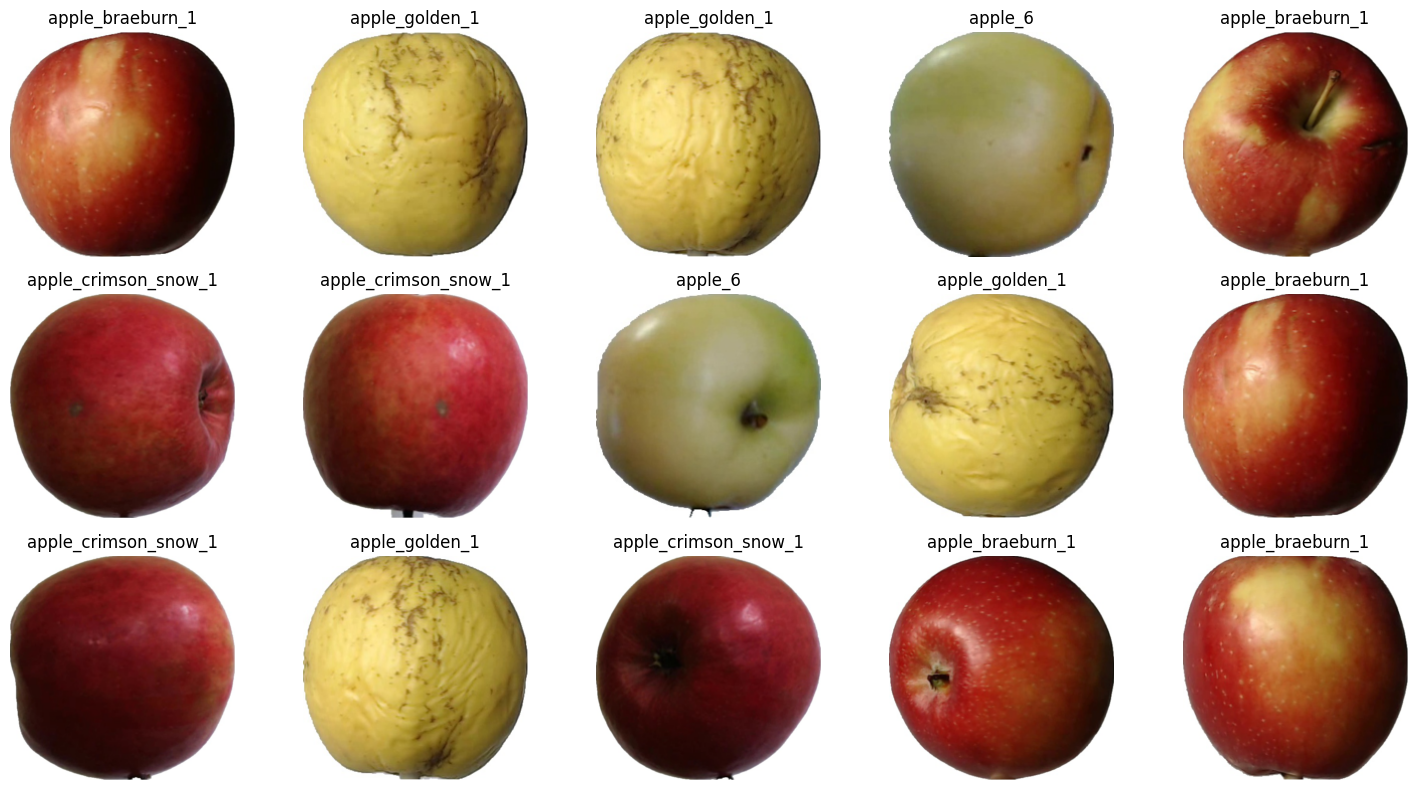

In [5]:
show_images(image_datasets[TRAIN], nb_rows=3, nb_cols=5, class_map=class_names)

# Model

In [6]:
input_size = (batch_size, 3, 224, 224)
model = vgg16(weights=VGG16_Weights.DEFAULT)
# summary(model)

In [7]:
n1 = count_trainable_parameters(model)
print("Number of trainable parameters", f"{n1:,d}")
# Freeze training for all layers
for param in model.parameters():
    param.require_grad = False
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(n_inputs, n_classes)
model = model.to(device)
n2 = count_trainable_parameters(model)
print("Custom model number of trainable parameters", f"{n2:,d}")
print(f"{(n1-n2):,d}")
summary(
    model,
    input_size=input_size,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Number of trainable parameters 138,357,544
Custom model number of trainable parameters 134,276,932
4,080,612


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 4]              --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

# Training

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(
    model=model,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs,
)

Epoch 0/2
	Batch [4/40], loss: 1.2690238654613495
	Batch [8/40], loss: 0.9933587685227394
	Batch [12/40], loss: 0.8175386289755503
	Batch [16/40], loss: 0.6941040996462107
	Batch [20/40], loss: 0.600143214315176


In [ ]:
é'ré"r

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

# Test

In [ ]:
model.eval()
test_losses = []
correct = 0
total = 0
with torch.no_grad():
    for batch_data in tqdm(dataloaders[TEST]):
        images = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        test_losses.append(loss.item())
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
average_test_loss = np.mean(test_losses)
print(f"Average Test Loss: {average_test_loss:.4f}")
accuracy = 100 * correct / total
print(f"Accuracy on Test Data: {accuracy:.2f}%")

In [ ]:
test_loader = dataloaders[TEST]
batch_idx, (images, labels) = next(enumerate(test_loader))
dataset = image_datasets[TEST]
model.eval()
with torch.no_grad():
    output = model(images)  
    fig, axes = plt.subplots(5, 3, figsize=(15, 8))
    predictions = output.argmax(dim=1)  
    for i, ax in enumerate(axes.flat):    
        if i >= len(predictions) :
            break    
        ax.imshow(images[i].numpy().transpose((1, 2, 0)))
        prediction = predictions[i].item()
        target = labels[i].item()
        ax.axis("off")
        ax.set_title(f"pred={class_names[prediction]}, real={class_names[target]}", color='green' if prediction == target else 'red')
    plt.show()